# Validação de Modelos

Este jupyter é utilizado para carregar os modelos treinados. Uma matriz de confusão é gerada para a análise do desempenho do modelo em cada classe. O modelo carregado neste jupyter é o do modelo limite encontrado na configuração de DF -> DA: 2057 -> 3617 RPM, com imagens STFT geradas de sinais de vibração.

## Importação de bibliotecas

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from adapt.parameter_based import FineTuning
import keras
import adapt
import seaborn as sns


In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.metrics import confusion_matrix

## Funções utilizadas

In [ ]:
def get_Xy(domain, path_to_folder= path):
    
    caminho_imagem = pasta + '/' + domain  + '/images/'
    X = []
    y = []

    for r, d, f in os.walk(caminho_imagem):
        for direct in d:
            if not ".ipynb_checkpoints" in direct:
                for r, d, f in os.walk(os.path.join(caminho_imagem , direct)):
                    for file in f:
                        path_to_image = os.path.join(r, file)
                        if not ".ipynb_checkpoints" in caminho_imagem:
                            image = Image.open(caminho_imagem)
                            image = image.resize((224, 224), Image.ANTIALIAS)
                            image = np.array(image, dtype=int)
                            X.append(image)
                            y.append(direct)
    return X, y


## Carregamento das imagens de validação

In [7]:
pasta = 'cole aqui o caminho para a pasta com o modelo salvo'

Xt, yt = get_Xy("Validacao")
Xt = preprocess_input(np.stack(Xt))

one = OneHotEncoder(sparse=False)
one.fit(np.array(yt).reshape(-1, 1))
yt_lab = one.transform(np.array(yt).reshape(-1, 1))

print("X target shape: %s"%str(Xt.shape))

X target shape: (3210, 224, 224, 3)


## Carregamento do modelo

In [8]:
mdd = tf.saved_model.load('cole aqui o caminho do modelo')

## Classificação das imagens de validação

In [9]:
batch_size = 32  # Escolha o tamanho do lote que você deseja

# Xt é o seu conjunto de dados de entrada

num_samples = Xt.shape[0]
num_batches = int(np.ceil(num_samples / batch_size))

predictions = []

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, num_samples)
    
    batch_data = Xt[start_idx:end_idx]  # Seleciona um lote de dados
    
    batch_predictions = mdd.__call__(batch_data)  # Faz previsões para o lote
    predictions.append(batch_predictions)

# Combine todas as previsões em um único array
all_predictions = np.vstack(predictions)


In [10]:

# arredondando as previsões para as classes (0 ou 1)
all_predictions = np.round(all_predictions)

# calculando a acurácia do modelo
accuracy = accuracy_score(yt_lab, all_predictions)

print('Acurácia do modelo: {:.2%}'.format(accuracy))


Acurácia do modelo: 70.87%


## Geração da matriz de confusão

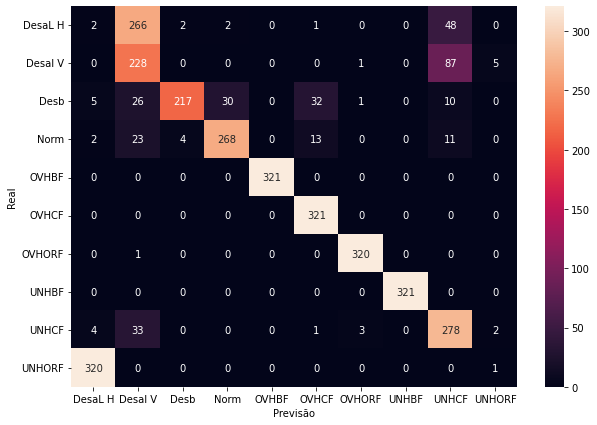

In [11]:
# Obtenção das classes reais e previstas
y_true = np.argmax(yt_lab, axis=1)
y_pred = np.argmax(all_predictions, axis=1)

# Cálculo da matriz de confusão
cm = confusion_matrix(y_true, y_pred)

# Criação do mapa de cores
cmap = sns.cubehelix_palette(light=1, as_cmap=True)

# Plot da matriz de confusão
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True,  fmt='g', 
            xticklabels=['DesaL H','Desal V','Desb','Norm','OVHBF','OVHCF','OVHORF','UNHBF','UNHCF','UNHORF'],
            yticklabels=['DesaL H','Desal V','Desb','Norm','OVHBF','OVHCF','OVHORF','UNHBF','UNHCF','UNHORF'])

plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()
